In [85]:
import numpy as np
from scipy.linalg import expm
import numpy.linalg as LA
import random

from qiskit import QuantumCircuit
from qiskit import Aer, transpile,execute
from qiskit.quantum_info import random_pauli, state_fidelity
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.tools.visualization import plot_histogram, plot_state_city

def create_entanglement(Nq, qc):
    qc.h(0)
    for i in range(1, Nq):
        qc.cx(0, i)
    qc.barrier()
    return qc

def create_hamiltonian(Nq, cn, gamma, Bn):
    '''
    create Hamiltonian gate
    target Hamiltonian is H=1/2*cn((1+gamma)XX+(1-gamma)YY)+BnZn
    Nq -> number of qubit
    cn -> coupling constant
    gamma -> parameter
    Bn -> Magnetic field
    '''
    
    XX= np.array(np.zeros(2**Nq))
    YY= np.array(np.zeros(2**Nq))
    Zn= np.array(np.zeros(2**Nq))
    Identity = 'I' * Nq
    hamiltonian = np.array(np.zeros(2**Nq))

    for k in range(0, Nq):
        hamiZ = Pauli(Identity[:k] + 'Z' + Identity[k+1:])
        Zn = Zn + Bn[k] * hamiZ.to_matrix()
    
    for k in range(0, Nq):
        '''
        隣あうqubitのみ相互作用するようなモデルを考える
        0 1 2 ... k-1 X X k+2 ... N-1
        0 1 2 ... k-1 Y Y k+2 ... N-1
        '''
        
        # 端まで計算したらスキップ
        if k == Nq-1:
            continue

        hamiX = Pauli(Identity[:k] + 'XX' + Identity[k+2:])
        hamiY = Pauli(Identity[:k] + 'YY' + Identity[k+2:])
                
#         print("hamiX: %s" % hamiX)
#         print("hamiY: %s" % hamiY)

        XX = XX + 0.5*cn[k]*(1+gamma)*hamiX.to_matrix()
        YY = YY + 0.5*cn[k]*(1-gamma)*hamiY.to_matrix()

    return XX + YY + Zn
        

In [88]:
qubit = 5
cn = [1] * qubit #[1,1,1,1,1]
r = 0
bn = [0] * qubit #[0,0,0,0,0]

qc1 = QuantumCircuit(qubit)
qc2 = QuantumCircuit(qubit)
qc1 = create_entanglement(qubit, qc1)
qc2 = create_entanglement(qubit, qc2)

for i in range(10):
    t = 1
    ## Hamiltonianの時間発展を計算
    hami = expm(-1j*create_hamiltonian(qubit,cn,r,bn)*t)
    qc1.append(Operator(hami),list(range(qubit)))
    qc2.append(Operator(hami),list(range(qubit)))
    num = random.randint(1, 100)
    if num < 2:
        p1 = random_pauli(2)
        p2 = random_pauli(qubit)
        qc1.append(p1, [0,1])
        qc2.append(p2, list(range(qubit)))

    


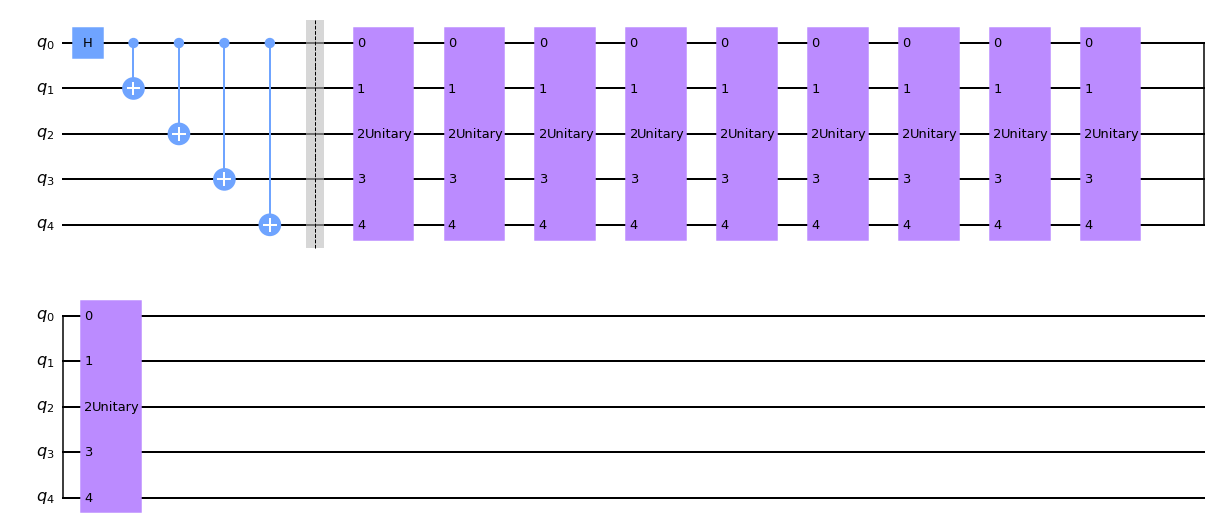

In [90]:
qc1.draw('mpl')

In [ ]:
backend = Aer.get_backend('unitary_simulator')
results = execute(qc1, backend=backend).result()
unitary_mat =results.get_unitary(qc1)
print(np.round(unitary_mat,4))

{'01100': 3, '01010': 1, '10111': 14, '00011': 23, '01001': 20, '10100': 140, '10001': 460, '11000': 135, '11101': 21, '00000': 62, '11110': 2, '10010': 49, '00101': 94}


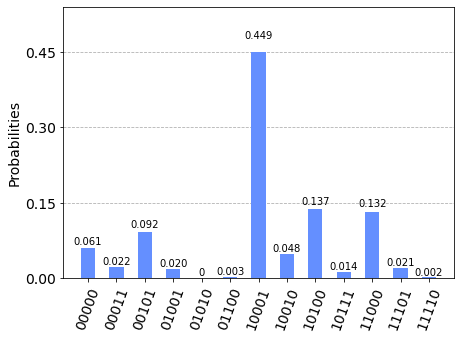

In [80]:
# Create a Quantum Circuit
meas = QuantumCircuit(qubit, qubit)
meas.barrier(range(qubit))
# map the quantum measurement to the classical bits
meas.measure(range(qubit), range(qubit))
circ = meas.compose(qc1, front=True)

## Noisy quantum circuit simulator backend
backend = Aer.get_backend('qasm_simulator')
job = backend.run(transpile(circ, backend), shots=1024)

# Grab the results from the job.
results_qasm = job.result()

counts = results_qasm.get_counts(circ)
print(counts)
plot_histogram(counts)


In [69]:
qubit = 5
cn = [1] * qubit #[1,1,1,1,1]
r = 0
bn = [0] * qubit #[0,0,0,0,0]

qc = QuantumCircuit(qubit)
for i in range(1000):
    t = 0.1
    ## Hamiltonianの時間発展を計算
    hami = expm(-1j*create_hamiltonian(qubit,cn,r,bn)*t)
    qc.append(Operator(hami),list(range(qubit)))
    num = random.randint(1, 100)
    if num < 2:
        qc.append(random_pauli(qubit), list(range(qubit)))


{'00010': 1, '11001': 7, '10000': 2, '00111': 14, '01101': 90, '10011': 80, '11100': 67, '10101': 40, '11010': 213, '11111': 101, '10110': 102, '00100': 58, '00001': 61, '01000': 160, '01110': 28}


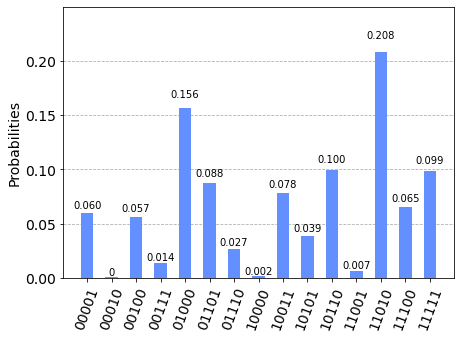

In [70]:
# Create a Quantum Circuit
meas = QuantumCircuit(qubit, qubit)
meas.barrier(range(qubit))
# map the quantum measurement to the classical bits
meas.measure(range(qubit), range(qubit))
circ = meas.compose(qc, front=True)

## Noisy quantum circuit simulator backend
backend = Aer.get_backend('qasm_simulator')
job = backend.run(transpile(circ, backend), shots=1024)

# Grab the results from the job.
results_qasm = job.result()

counts = results_qasm.get_counts(circ)
print(counts)
plot_histogram(counts)
